# Differentiating the PPG signal
Differentiating the PPG signal is a key step in identifying fiducial points on PPG pulse waves.

---
## Specify an ICU stay and segment

<div class="alert alert-block alert-warning"> <b>Resource:</b> These steps are taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/data-visualisation.html">Data Visualisation</a> tutorial. </div>

- Specify the required Python packages

In [2]:
import sys
import wfdb

- Get a list of ICU stays in the database

In [3]:
database_name = 'mimic3wdb/1.0' # The name of the MIMIC III Waveform Database on Physionet (see URL: https://physionet.org/content/mimic3wdb/1.0/)
icustay_records = wfdb.get_record_list(database_name)
print("There are {} ICU stays in the database".format(len(icustay_records)))

There are 67830 ICU stays in the database


- Specify an ICU stay

In [4]:
icustay_no = 10 # specify the first record (noting that in Python the first index is 0)
icustay_record = icustay_records[icustay_no]
icustay_record_dir = database_name + '/' + icustay_record
icustay_record_name = icustay_record.split("/")[1]
print("Specified ICU stay: {}".format(icustay_record_name))

Specified ICU stay: 3000125


- Specify a segment of this ICU stay

In [5]:
icustay_files = wfdb.get_record_list(icustay_record_dir)
icustay_segments = [s for s in icustay_files if "_" in s]
icustay_segment_no = 4;
icustay_segment_name = icustay_segments[icustay_segment_no]
print("Specified segment: '{}' within ICU stay '{}'".format(icustay_segment_name, icustay_record_name))

Specified segment: '3000125_0005' within ICU stay '3000125'


---
## Extract data for this segment
<div class="alert alert-block alert-warning"> <b>Resource:</b> These steps are taken from the <a href="https://wfdb.io/mimic_wfdb_tutorials/tutorial/notebooks/data-visualisation.html">Data Visualisation</a> tutorial. </div>

- Specify the timings of the data to be extracted

In [6]:
start_seconds = 60 # time since the start of the segment at which to begin extracting data
no_seconds_to_load = 5

- Find out the sampling frequency of the waveform data

In [7]:
segment_metadata = wfdb.rdheader(record_name=icustay_segment_name, pn_dir=icustay_record_dir)
fs = segment_metadata.fs

- Extract the specified data

In [8]:
sampfrom = fs*start_seconds
sampto = fs*(start_seconds+no_seconds_to_load)
segment_data = wfdb.rdrecord(record_name=icustay_segment_name, sampfrom=sampfrom, sampto=sampto, pn_dir=icustay_record_dir) 
print("{} seconds of data extracted from: {}".format(no_seconds_to_load, icustay_segment_name))

5 seconds of data extracted from: 3000125_0005


---
## Extract the PPG signal

- Extract the PPG signal from the segment data

In [54]:
ppg = segment_data.p_signal[:,2]

---
## Filter the PPG signal

- Import the [SciPy signal processing package](https://docs.scipy.org/doc/scipy/tutorial/signal.html), which contains functions for filtering and differentiating.

In [55]:
import scipy.signal as sp

- Filter the PPG signal in preparation for differentiation using a Butterworth filter provided by the [butter](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.butter.html) function.

<div class="alert alert-block alert-warning"> <b>Explanation:</b> This function generates the co-efficients for a Butterworth filter. The filter-type is specified as 'bp' - a bandpass filtter. The filter frequencies are specified in Hz (because the sampling frequency, fs, has also been specified): a high-pass frequency of 0.7 Hz, and a low-pass frequency of 10 Hz. </div>

In [74]:
sos_ppg = sp.butter(10, [0.7, 10], btype = 'bp', analog = False, output = 'sos', fs = segment_data.fs)
w, h = sp.sosfreqz(sos_ppg, 2000, fs = fs)
ppg_filt = sp.sosfiltfilt(sos_ppg, ppg)

- Import the packages required to plot the signal: [matplotlib](https://matplotlib.org/stable/index.html) which is used to create plots, and [NumPy](https://numpy.org/) which is used to create a time vector in this example.

In [75]:
from matplotlib import pyplot as plt
import numpy as np

- Plot the original and the filtered PPG signal

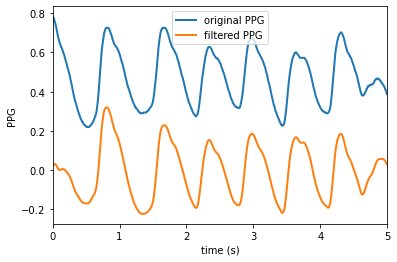

In [76]:
fig, ax = plt.subplots()
t = np.arange(0, len(ppg_filt))/segment_data.fs
ax.plot(t, ppg, linewidth=2.0, label = "original PPG")
ax.plot(t, ppg_filt, linewidth=2.0, label = "filtered PPG")
ax.set(xlim=(0, no_seconds_to_load))
plt.xlabel('time (s)')
plt.ylabel('PPG')

plt.legend()
plt.show()

- We will use the filtered signal instead of the original PPG from now on.

---
## Differentiate the PPG signal

- Differentiate it once and twice using the [Savitzky-Golay filtering](https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.savgol_filter.html) function in SciPy

In [77]:
d1ppg = sp.savgol_filter(ppg_filt, 9, 5, deriv=1) # Calculate first derivative
d2ppg = sp.savgol_filter(ppg_filt, 9, 5, deriv=2) # Calculate second derivative

<div class="alert alert-block alert-warning"> <b>Resource:</b> Savitzky-Golay filtering, which is used here to calculate derivatives, is described in <a href="https://doi.org/10.1021/ac60214a047">this article</a>. </div>

---
## Plot the PPG and its derivatives

In [78]:
from matplotlib import pyplot as plt
import numpy as np

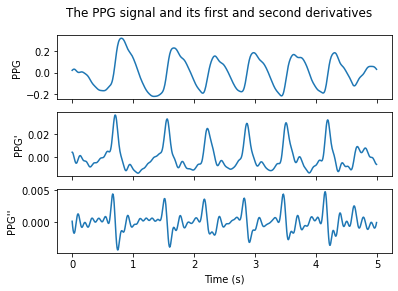

In [79]:
t = np.arange(0, len(ppg_filt))/segment_data.fs
fig, (ax1,ax2,ax3) = plt.subplots(3, 1, sharex = True, sharey = False)
ax1.plot(t, ppg_filt)
ax1.set(xlabel = '', ylabel = 'PPG')
plt.suptitle('The PPG signal and its first and second derivatives')
ax2.plot(t, d1ppg)
ax2.set(xlabel = '', ylabel = 'PPG\'')
ax3.plot(t, d2ppg)
ax3.set(xlabel = 'Time (s)', ylabel = 'PPG\'\'')
plt.show()

<div class="alert alert-block alert-info"> <b>Q:</b> How would the derivatives have looked different if the PPG signal hadn't been filtered before differentiation? <br> <b>Hint:</b> Above, try replacing 'ppg = ppg_ff' with 'ppg = ppg'. </div>

<div class="alert alert-block alert-info"> <b>Q:</b> How would the derivatives have been different if the PPG signal had been filtered using different co-efficients?
    <br> <b>Hint:</b> Above, try replacing the relatively wide band-pass frequencies '[0.7, 10]' with '[0.8, 3]'. 
    <br> <b>Consider:</b> Which band-pass frequencies would be most suitable for pulse wave analysis? How about heart rate estimation?
</div>